In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm

import datetime
import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import get_covid19india_api_data
from data.processing import get_data

from models.seir.seir_testing import SEIR_Testing
from models.seir.seirhd import SEIRHD
from models.seir.seir_movement import SEIR_Movement
from models.seir.seir_movement_testing import SEIR_Movement_Testing

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv
from utils.create_report import create_report
from viz import plot_forecast

## Load Covid19india Data

In [144]:
dataframes = get_covid19india_api_data()

In [145]:
predictions_dict = {}

## Select Districts to fit on

In [148]:
districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

Performing m1 fit ..
fetching from athenadb...
6191
smoothing length truncated to 30
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
39 2020-05-22  maharashtra   mumbai         27062.6       14906.8    11242.0   
40 2020-05-23  maharashtra   mumbai         28633.4       15737.8    11944.8   
41 2020-05-24  maharashtra   mumbai         30128.2       16448.2    12692.6   
42 2020-05-25  maharashtra   mumbai         31481.6       17011.4    13445.2   
43 2020-05-26  maharashtra   mumbai         32809.4       17474.0    14273.2   

    deceased  
39     913.8  
40     950.8  
41     987.4  
42    1025.0  
43    1062.2  
val
         date        state district  total_infected  hospitalised  recovered  \
0 2020-05-27  maharashtra   mumbai         34079.6       18063.8    14916.6   
1 2020-05-28  maharashtra   mumbai         35365.8       18731.6    15494.8   
2 2020-05-29  maharashtra   mumbai         36700.4       19

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


100%|██████████| 700/700 [00:26<00:00, 25.99trial/s, best loss: 3.071660539608888] 
best parameters
 {'E_hosp_ratio': 0.5529076052283, 'I_hosp_ratio': 0.3833623896652238, 'P_fatal': 0.07594929435708085, 'T_inc': 4.326687605022422, 'T_inf': 3.8006266743870536, 'T_recov_severe': 18.90048361843035, 'lockdown_R0': 1.4094476425918527}
Performing m2 fit ..
fetching from athenadb...
6191
smoothing length truncated to 30
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
46 2020-05-29  maharashtra   mumbai         36700.4       19508.8    16009.4   
47 2020-05-30  maharashtra   mumbai         38108.8       20450.0    16432.2   
48 2020-05-31  maharashtra   mumbai         39451.4       21505.0    16673.2   
49 2020-06-01  maharashtra   mumbai         40877.0       22571.0    16987.0   
50 2020-06-02  maharashtra   mumbai         41986.0       23405.0    17213.0   

    deceased  
46    1182.2  
47    1226.6  
48    1273.2  

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


100%|██████████| 700/700 [00:27<00:00, 25.55trial/s, best loss: 2.526789052787109] 
best parameters
 {'E_hosp_ratio': 0.1862048853782785, 'I_hosp_ratio': 0.2695562866419517, 'P_fatal': 0.07015965899618341, 'T_inc': 4.228160346757089, 'T_inf': 3.14847342119975, 'T_recov_severe': 46.21760802340927, 'lockdown_R0': 1.3740550813075856}


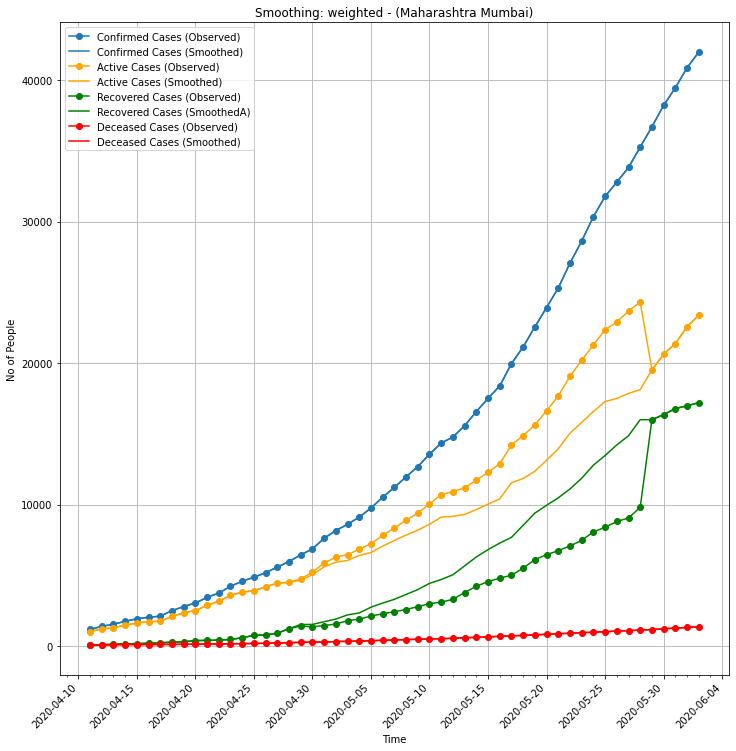

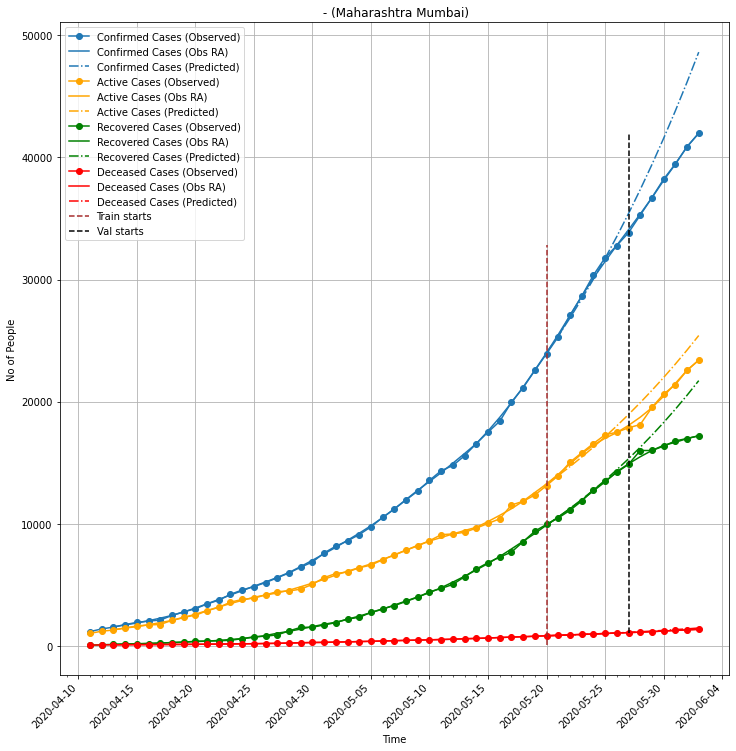

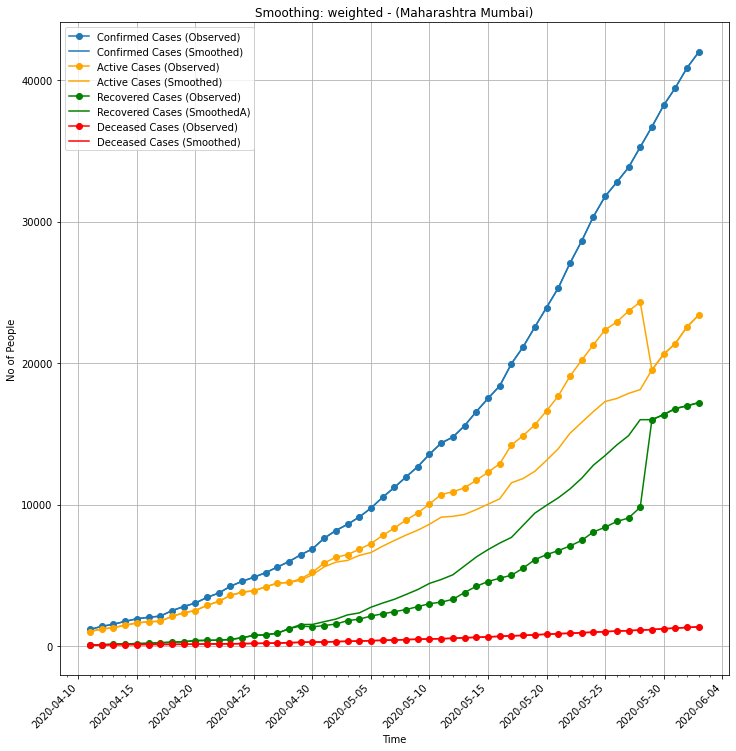

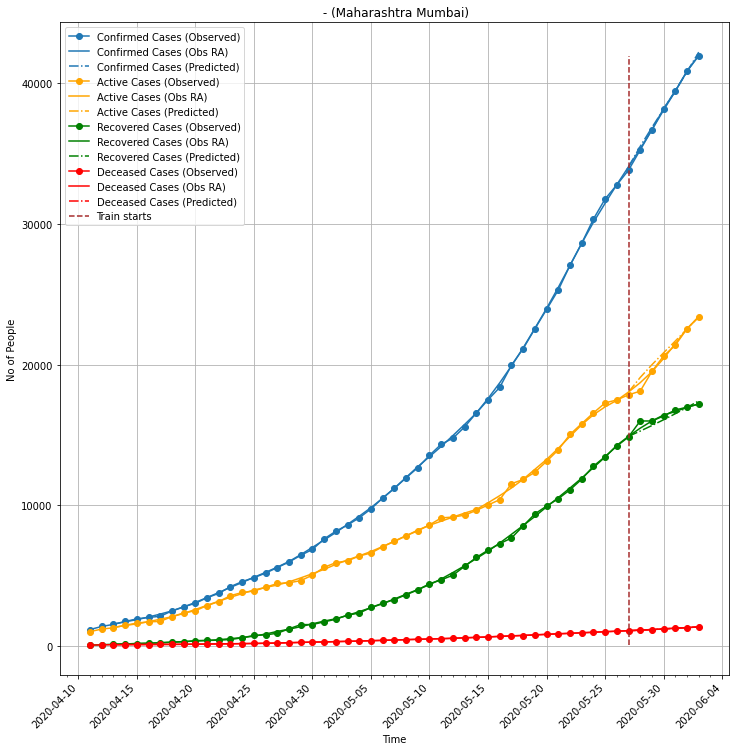

In [158]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=7, model=SEIR_Testing,
        data_from_tracker=False, initialisation='intermediate', num_evals=700, 
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'],
        smooth_jump=True, smoothing_length=33, smoothing_method='weighted', smooth_plot=True)
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=0, num_evals=700,
        data_from_tracker=False, initialisation='intermediate', model=SEIR_Testing, 
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'],
        smooth_jump=True, smoothing_length=33, smoothing_method='weighted', smooth_plot=True)
    
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
    predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

## Create Master Loss Dataframe

### M1 Loss

In [137]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                            val  \
                 hospitalised total_infected deceased recovered hospitalised   
Maharashtra Pune         1.98           0.45     1.08      3.12         8.83   

                                                    
                 total_infected deceased recovered  
Maharashtra Pune           4.83     7.33      3.18

### M2 Loss

In [138]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                 hospitalised total_infected deceased recovered
Maharashtra Pune         4.31           1.43     1.22      3.39

## Plot Forecasts

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


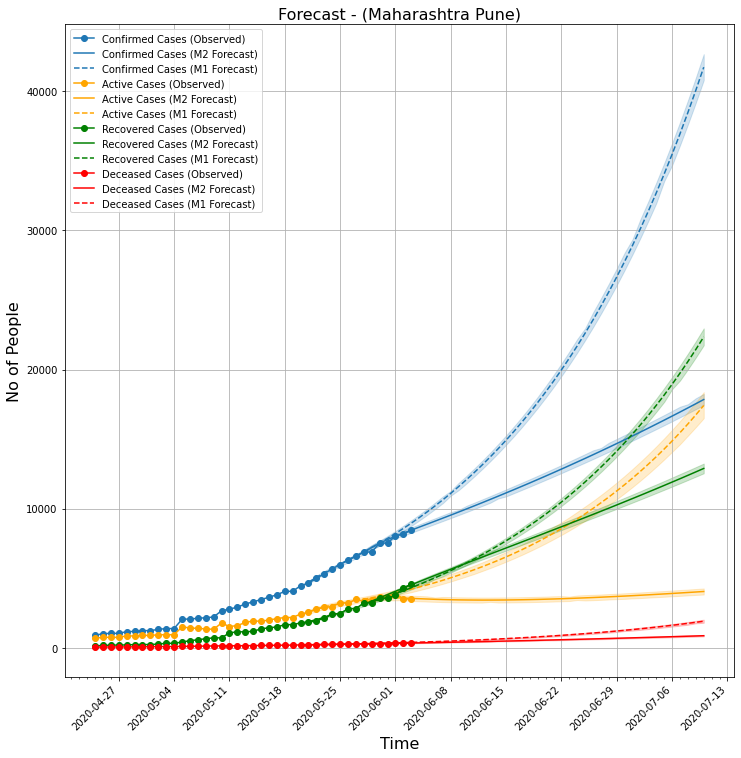

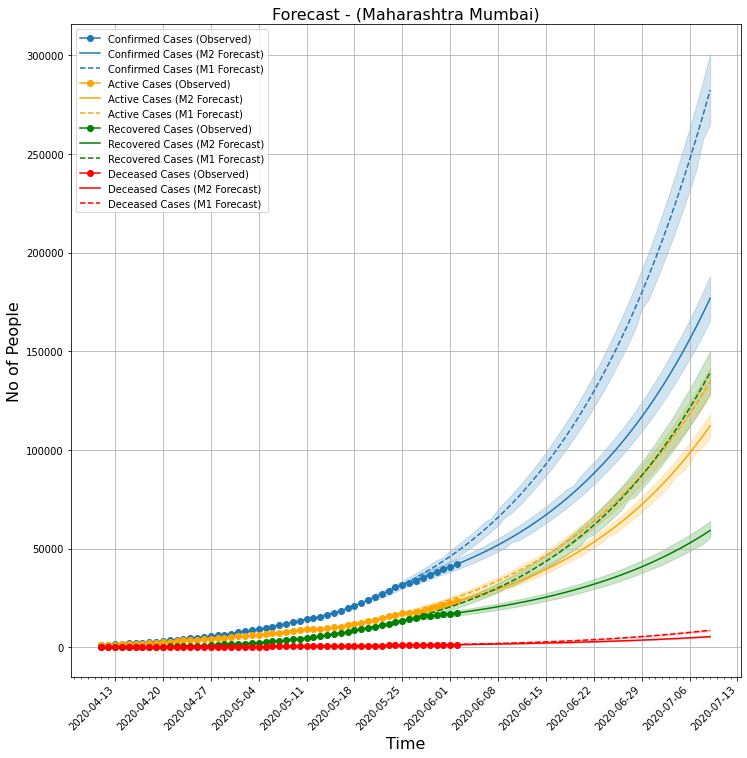

In [159]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=True, error_bars=True)

## Create Report

In [118]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region])

## Create and Save Output CSV

In [119]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [120]:
write_csv(df_output)